In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from datetime import datetime
from astropy.table import Table
from astropy.time import Time
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
import math
from matplotlib import gridspec
from numba import jit
from celluloid import Camera
import matplotlib.image as mpimg

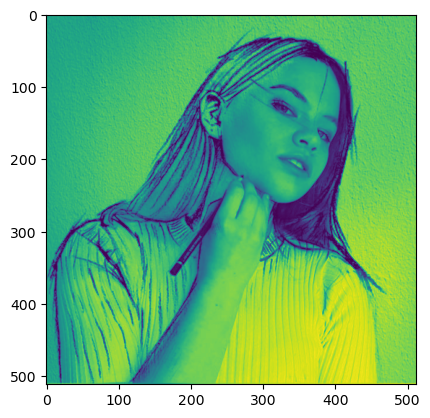

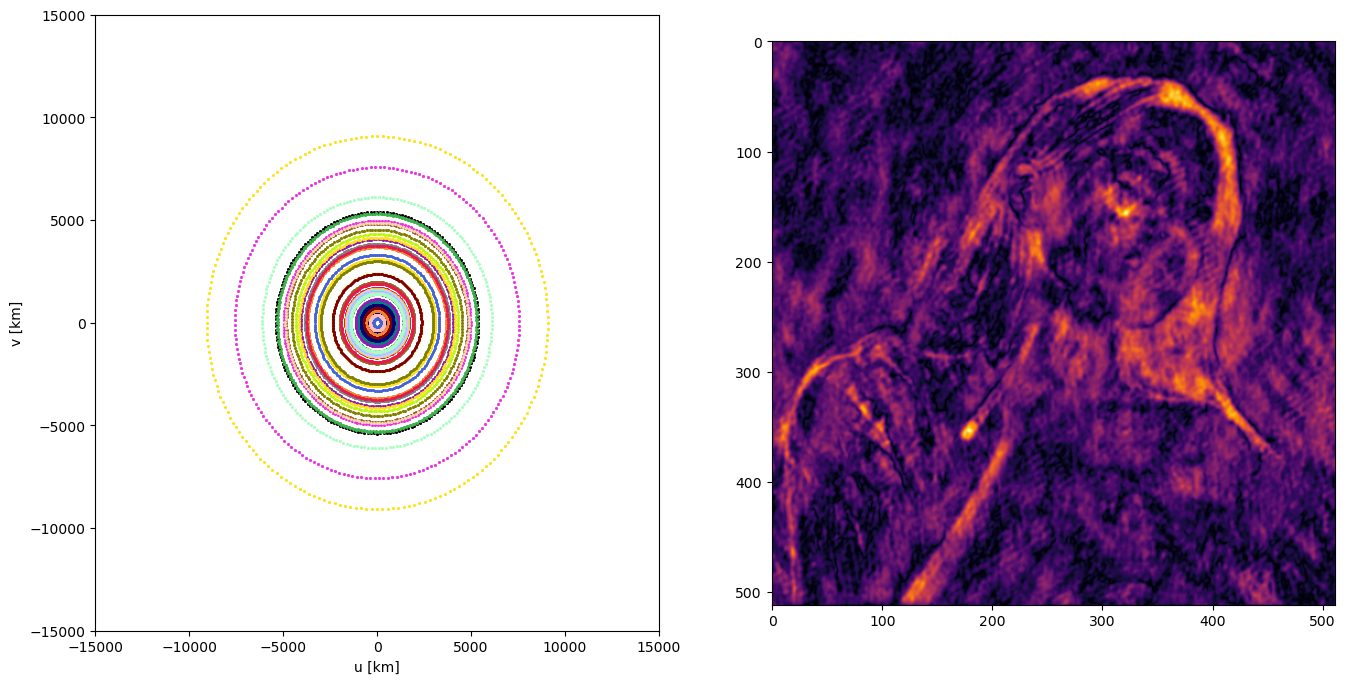

In [14]:
r_e=6731 #Earth Radius in Kilometers
elev_lim=0 #elevetion limit for telescopes in degree
imgSize=512 #pixelsize of image
plotLim=15000 #max plot length of baselines
n_iter=200 #number of iterations
do_world_map=False #decide whether to show world map or not

#create real image 
real_image=np.zeros((imgSize,imgSize))
#point source in center
real_image[math.floor(imgSize/2)][math.floor(imgSize/2)]=1
#point source 2
real_image[math.floor(imgSize/2)+20][math.floor(imgSize/2)]=1
#point source 3
real_image[math.floor(imgSize/2)][math.floor(imgSize/2)+20]=1



#upload custom image
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b #standard grayscale conversion
    return gray

img_import = mpimg.imread('paula.png')
real_image = rgb2gray(img_import)
plt.imshow(real_image)
plt.show()


real_image_fft=np.fft.fftshift(np.fft.fft2(real_image))


#define custom telescopes
telescopes=[[50.1905748,11.789879],[49.783333,9.933333],[48.137154,11.576124]]

vlba=[[42.93362, -71.98681],[41.77165, -91.574133],[30.635214, -103.944826],
      [35.775289, -106.24559],[34.30107, -108.11912],[31.956253, -111.612361],
      [37.23176, -118.27714],[48.13117, -119.68325],[19.80159, -155.45581],[17.75652, -64.58376]]

#use vlba preset
telescopes=vlba

#calculate number of baselines
n_baselines=int(len(telescopes)*(len(telescopes)-1)/2)

#source position
source=[30,90] #ra,dec of source

#calculate u-v transformation matrix from source coordinates
H=source[0]/180*np.pi
delta=source[1]/180*np.pi
#matrix=np.array([[np.sin(H),-np.sin(delta)*np.cos(H),np.cos(delta)*np.cos(H)],
#                [np.cos(H),np.sin(delta)*np.sin(H),-np.cos(delta)*np.sin(H)],
#                [0,np.cos(delta),np.sin(delta)]])
matrix=np.array([[np.sin(H),np.cos(H),0],
                 [-np.sin(delta)*np.cos(H),np.sin(delta)*np.sin(H),np.cos(delta)],
                [np.cos(delta)*np.cos(H),-np.cos(delta)*np.sin(H),np.sin(delta)]])

colors=['#e6194b', '#3cb44b', '#ffe119', '#4363d8',
        '#f58231', '#911eb4', '#46f0f0', '#f032e6',
        '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3',
        '#808000', '#ffd8b1', '#000075', '#808080',
        '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
        '#f58231', '#911eb4', '#46f0f0', '#f032e6',
        '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3',
        '#808000', '#ffd8b1', '#000075', '#808080',
        '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
        '#f58231', '#911eb4', '#46f0f0', '#f032e6',
        '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3',
        '#808000', '#ffd8b1', '#000075', '#808080',
        '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
        '#f58231', '#911eb4', '#46f0f0', '#f032e6',
        '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3',
        '#808000', '#ffd8b1', '#000075', '#808080',
        '#000000','#e6194b', '#3cb44b', '#ffe119', '#4363d8',
        '#f58231', '#911eb4', '#46f0f0', '#f032e6',
        '#bcf60c', '#fabebe', '#008080', '#e6beff',
        '#9a6324', '#fffac8', '#800000', '#aaffc3',
        '#808000', '#ffd8b1', '#000075', '#808080',
        '#000000']


#convert polar coordinates to cartesian
@jit(nopython=True)
def Pol2Cart(r,phi,delta):
    x = r * np.cos(delta/180*np.pi) * np.cos(phi/180*np.pi)
    y = - r * np.cos(delta/180*np.pi) * np.sin(phi/180*np.pi)
    z = r * np.sin(delta/180*np.pi)
    
    return np.array([x,y,z])

@jit(nopython=True)
def getUV(Tel1,Tel2,matrix):
    baseline=Tel2-Tel1
    
    return np.dot(matrix,baseline)


source_vector=Pol2Cart(r_e,source[0],source[1])

u_v_grid=np.zeros((imgSize,imgSize))
pixelSize=plotLim*2/imgSize

#create array to save uv_tracks for every baseline
u_v_tracks=[[[],[]] for x in range(n_baselines)]

def animate(i):
    
    print(str(i+1)+"/"+str(n_iter),end="\r")
    t=360/n_iter*i
    #convert all telescope positions to cartesian coordinates
    tels=np.empty(shape=(len(telescopes), 3))
    tel_visible=np.empty(len(telescopes)) #array to store boolean information whether telescope can see the source or not
    for ind,telescope in enumerate(telescopes):
        new_lat=telescope[1]+t
        if new_lat>180:
            new_lat=new_lat-360
            
        if do_world_map:
            ax=plt.subplot(gs_world,projection="aitoff")
            plt.scatter(new_lat/180*np.pi,telescope[0]/180*np.pi,marker="*",s=400,c="r")
        
        tel=Pol2Cart(r_e,new_lat,telescope[0])
        tels[ind]=tel
        
        #determine whether source is visible to telescope
        if np.dot(tel,source_vector)/r_e**2<np.cos((90-elev_lim)/180*np.pi):
            tel_visible[ind]=False
        else:
            tel_visible[ind]=True
        
        
    
    baseline_count=0
    for k in range(len(tels)):
        if k<len(tels)-1:
            for j in range(k+1,len(tels)):
                if tel_visible[k] and tel_visible[j]:
                    
                    #plot baseline in world map
                    if do_world_map:
                        ax=plt.subplot(gs_world)
                        plt.plot([(telescopes[k][1]+t)/180*np.pi,(telescopes[j][1]+t)/180*np.pi],
                                 [(telescopes[k][0])/180*np.pi,(telescopes[j][0])/180*np.pi],
                                 c=colors[baseline_count])
                    
                    #get new u_v data point
                    baseline_uv=getUV(tels[k],tels[j],matrix)
                    u=baseline_uv[0]
                    v=baseline_uv[1]
                    
                    #append new u_v point to baseline u_v track
                    u_array=u_v_tracks[baseline_count][0].append(u)
                    v_array=u_v_tracks[baseline_count][1].append(v)
                    
                    #change u_v_sampling grid
                    x_ind=math.floor((u+plotLim)/pixelSize)
                    y_ind=math.floor((v+plotLim)/pixelSize)
                    
                    u_v_grid[y_ind][x_ind]=1
                    
                    x_ind=math.floor((-u+plotLim)/pixelSize)
                    y_ind=math.floor((-v+plotLim)/pixelSize)
                    
                    u_v_grid[y_ind][x_ind]=1
                
                #plot current status of uv_tracks
                u_plot=u_v_tracks[baseline_count][0]
                v_plot=u_v_tracks[baseline_count][1]
                ax = plt.subplot(gs_uv)
                plt.scatter(u_plot,v_plot,c=colors[baseline_count],s=1)
                plt.scatter(-np.array(u_plot),-np.array(v_plot),c=colors[baseline_count],s=1)
                baseline_count+=1
    
    ax=plt.subplot(gs_image)
    u_v_grid_new=u_v_grid*real_image_fft
    new_dirty_image=np.abs(np.fft.ifft2(np.fft.fftshift(u_v_grid_new)))
    plt.imshow(new_dirty_image,cmap="inferno")
    
    camera.snap()    

if do_world_map:
    fig = plt.figure(figsize=(24,8))
    gs= gridspec.GridSpec(1,3,height_ratios=[1])
    gs_world=gs[0]
    gs_uv=gs[1]
    gs_image=gs[2]
else:
    fig = plt.figure(figsize=(16,8))
    gs= gridspec.GridSpec(1,2,height_ratios=[1])
    gs_uv=gs[0]
    gs_image=gs[1]
    
camera = Camera(fig)
ax = plt.subplot(gs_uv)

plt.xlabel("u [km]")
plt.ylabel("v [km]")
plt.ylim(-plotLim,plotLim)
plt.xlim(-plotLim,plotLim)

if do_world_map:
    ax=plt.subplot(gs_world,projection="aitoff")
    plt.grid(True)
                
#anim=FuncAnimation(fig, animate, frames=n_iter, repeat=False,cache_frame_data=False)
#anim.save('uvcover.mp4', writer = 'ffmpeg', fps = 4)

for i in range(n_iter):
    animate(i)


anim = camera.animate(blit=True)
anim.save('dots.mp4', writer='ffmpeg')
plt.show()

In [ ]:
plt.imshow(u_v_grid)
plt.show()